In [1]:
import numpy as np
import pandas as pd

from Datasets.utk_face import UTKFaceDataset

#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

import copy

In [2]:
# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [3]:
# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 16

# Number of channels in the training images. For color images this is 3
nc = 3

# Number of training epochs
num_epochs = 300

# Number of epochs of increasing validation loss to wait before early stopping
patience = 15

# Learning rate for optimizers
lr = 0.0002

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Create the dataloader
dataloader = torch.utils.data.DataLoader(UTKFaceDataset(), batch_size=batch_size,
                                        shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("mps")

torch.Size([16, 3, 200, 200])


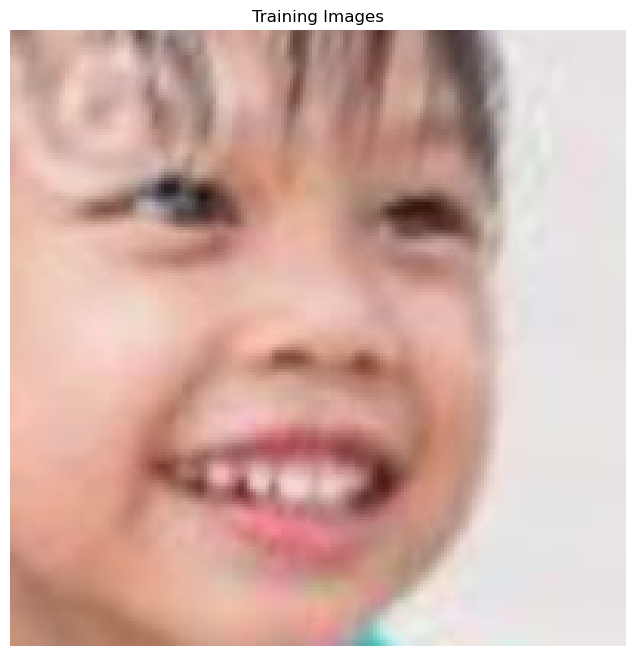

In [4]:
# Plot some training images
images, label = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
print(images.shape)
plt.imshow(np.transpose(vutils.make_grid(images[0].to(device), padding=2, normalize=False).cpu(),(1,2,0)))
plt.show()

In [6]:
z = 1024
layers = [
    nn.Conv2d(3, 16, 6, stride=2),
    nn.LeakyReLU(),
    nn.Conv2d(16, 8, 4, stride=2),
    nn.LeakyReLU(),
    nn.Conv2d(8, 4, 4, stride=2),
    nn.LeakyReLU(),

    nn.Flatten(),
    nn.LazyLinear(z),
    nn.ReLU(),
    nn.Linear(z, z)
]

from vae import Autoencoder

/opt/homebrew/anaconda3/envs/VAE/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
model = Autoencoder(layers).to(device)

best_model, best_loss = None, np.inf
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
history = []

train_batches = 100
valid_batches = 20
for epoch in range(num_epochs):
    data_iter = iter(dataloader)

    total_train_loss = 0
    for batch in range(train_batches):
        images, labels = next(data_iter)

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        recon = model(images)

        loss = criterion(images, recon)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * batch_size
    
    train_loss = total_train_loss / (batch_size * train_batches)
    print("Train loss:", train_loss)

    total_valid_loss = 0
    for batch in range(train_batches, train_batches+valid_batches):
        images, labels = next(data_iter)

        images = images.to(device)
        labels = labels.to(device)

        recon = model(images)

        loss = criterion(images, recon)

        total_valid_loss += loss.item() * batch_size

    valid_loss = total_valid_loss / (batch_size * valid_batches)
    print("Valid loss:", valid_loss)

    if (valid_loss < best_loss):
        best_loss = valid_loss
        best_model = copy.deepcopy(model)

    if (len(history) >= patience and valid_loss > history[-patience][1]):
        break

    history.append((train_loss, valid_loss))

model = best_model
    

Train loss: 0.16120427433401346
Valid loss: 0.05114997457712889
Train loss: 0.04907665330916643
Valid loss: 0.048823246732354164
Train loss: 0.04650139424949885
Valid loss: 0.04287468567490578
Train loss: 0.039576974529773
Valid loss: 0.032346509676426646
Train loss: 0.0317590281739831
Valid loss: 0.030085496604442596
Train loss: 0.030075667686760427
Valid loss: 0.029194476921111344
Train loss: 0.028935347925871612
Valid loss: 0.026384269073605537
Train loss: 0.028207263518124817
Valid loss: 0.027323157992213964
Train loss: 0.026852925792336464
Valid loss: 0.027327746897935868
Train loss: 0.024630837198346852
Valid loss: 0.02431692024692893
Train loss: 0.022253246689215304
Valid loss: 0.021550277993083
Train loss: 0.021645008865743876
Valid loss: 0.02211543945595622
Train loss: 0.020577616952359677
Valid loss: 0.02077603302896023
Train loss: 0.020075489431619645
Valid loss: 0.01944827502593398
Train loss: 0.019417828246951103
Valid loss: 0.019076129142194986
Train loss: 0.0186841936036

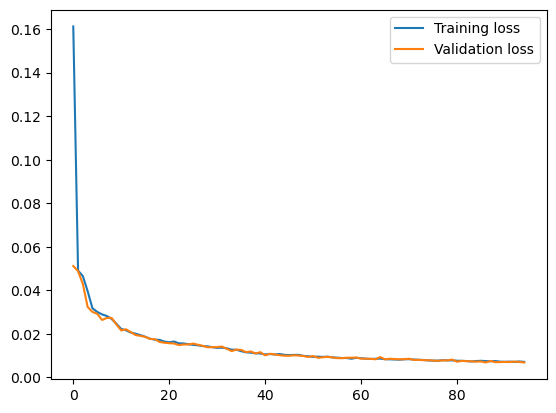

In [8]:
plt.plot(history)
plt.legend(["Training loss", "Validation loss"])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


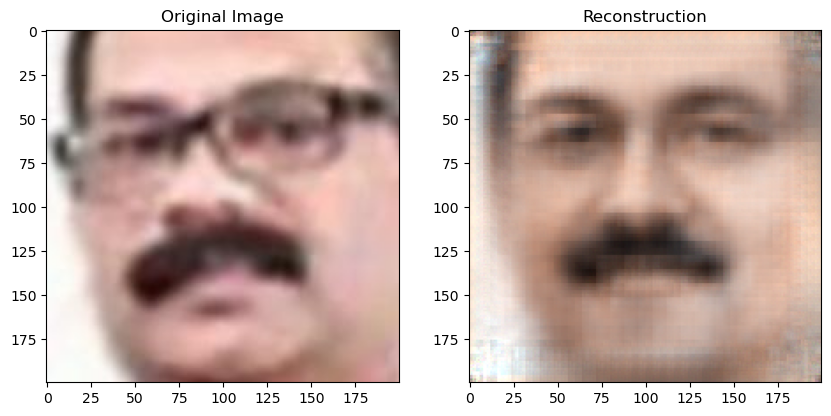

In [17]:
# Plot some training images
images, label = next(data_iter)
plt.figure(figsize=(10,5))
plt.axis("off")
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(np.transpose(vutils.make_grid(images[0].to(device), padding=2, normalize=False).cpu(),(1,2,0)))

with torch.no_grad():
    recon = model(images.to(device))

plt.subplot(1,2,2)
plt.title("Reconstruction")
plt.imshow(np.transpose(vutils.make_grid(recon[0].to(device), padding=2, normalize=False).cpu(),(1,2,0)))
plt.show()